In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, Dataset
import copy

from scipy.spatial.distance import cdist

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')

# from utils import *

from sklearn.metrics import f1_score

import pickle

/home/tomas/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Functions

In [2]:
def read_data(pathin):
    ''''''
    # Define the header names for the 'x' CSV files
    x_header = ["accx", "accy", "accz", "gyrox", "gyroy", "gyroz"]
    # Define the header names for the 'x_time' CSV files
    x_time_header = ["seconds"]

    # Define the header names for the 'y' CSV files
    y_header = ["class"]

    # Define the header names for the 'y_time' CSV files
    y_time_header = ["seconds"]

    # Create an empty list to store the dataframes
    dct = {}

    filesAll = [x for x in os.listdir(pathin) if x.endswith('.csv')]

    nSubjects = 8

    for i in range(nSubjects):
        print(f'Subject {i+1}')
        files = sorted([x for x in filesAll if x.startswith(f'subject_{i+1:03d}')])
        nSessions = int(len(files)/4) ## 4 files per session
        print(f'  N sessions: {nSessions}')
        
        xdataAll = []
        ydataAll = []

        for j in range(nSessions):
            xdata = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__x.csv', header = None, names = x_header)
            xdata['session'] = [j+1]*len(xdata)
            xtime = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__x_time.csv', header = None, names = x_time_header)
            xdata['time'] = xtime['seconds'].values
            xdataAll.append(xdata)

            ydata = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__y.csv', header = None, names = y_header)
            ydata['session'] = [j+1]*len(ydata)
            ytime = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__y_time.csv', header = None, names = y_time_header)
            ydata['time'] = ytime['seconds'].values
            ydataAll.append(ydata)
        
        print(f'    Number of X files: {len(xdataAll)}')
        print(f'    Number of y files: {len(ydataAll)}')
        dfx = pd.concat(xdataAll)
        dfx.index = range(len(dfx))
        dfy = pd.concat(ydataAll)
        dfy.index = range(len(dfy))

        dct[f'subject_{i+1}_x'] = dfx
        dct[f'subject_{i+1}_y'] = dfy
    return dct

In [3]:
def upsampleData(dct):
    ## Upsample y values, NN interpolation in time column
    dct_ups = {}

    for k in range(int(len(dct.keys())/2)):
        xkey = f'subject_{k+1}_x'
        ykey = f'subject_{k+1}_y'
        dfx = dct[xkey]
        dfy = dct[ykey]

        print(f'subject {k+1}')
        dfout = []
        
        dfunb = pd.DataFrame(index = dfx['session'].unique(), columns = dfy['class'].unique(), data = 0)
        dfunb['sum'] = [np.nan]*len(dfunb)

        i = 0
        for s in dfx['session'].unique():
            print(f'  upsampling session {s}')
            dfxs = dfx[dfx['session'] == s]
            print(f'    len X: {len(dfxs)}')
            dfys = dfy[dfy['session'] == s]
            print(f'    len y: {len(dfys)}')
            distm = cdist(dfxs['time'].values.reshape(len(dfxs), 1), dfys['time'].values.reshape(len(dfys), 1))
            dfxs['class'] = dfys.iloc[distm.argmin(1), 0].values
            dfxs['class_time'] = dfys.iloc[distm.argmin(1), 2].values
            del distm
            dfxs.index = range(i, len(dfxs)+i)
            print(f'    len data: {len(dfxs)}')
            dfout.append(dfxs)
            i += len(dfxs)
        dfout = pd.concat(dfout, axis = 0)
        print(f'    len total data subject {k+1}: {len(dfout)}')
        dct_ups[f'subject_{k+1}'] = dfout
    
    return dct_ups

In [4]:
def countBalance(dct, threshold = 2):

    dctBal = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}

    for k in dctBal.keys():

        for i in dct[k].index:
            aux = dct[k].loc[i, :]
            aux2 = aux.sort_values(ascending = False)
            aux2.iloc[0] = aux2.iloc[1]

            if aux2.iloc[1] > threshold * aux2.iloc[2]:
                aux2.iloc[0] = threshold * aux2.iloc[2]
                aux2.iloc[1] = threshold * aux2.iloc[2]

            dctBal[k].loc[i, aux2.index] = aux2.values
    return dctBal

#### Code

In [5]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'./TrainingData')
dctData = read_data(pathData)

Subject 1
  N sessions: 8
    Number of X files: 8
    Number of y files: 8
Subject 2
  N sessions: 5
    Number of X files: 5
    Number of y files: 5
Subject 3
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 4
  N sessions: 2
    Number of X files: 2
    Number of y files: 2
Subject 5
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 6
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 7
  N sessions: 4
    Number of X files: 4
    Number of y files: 4
Subject 8
  N sessions: 1
    Number of X files: 1
    Number of y files: 1


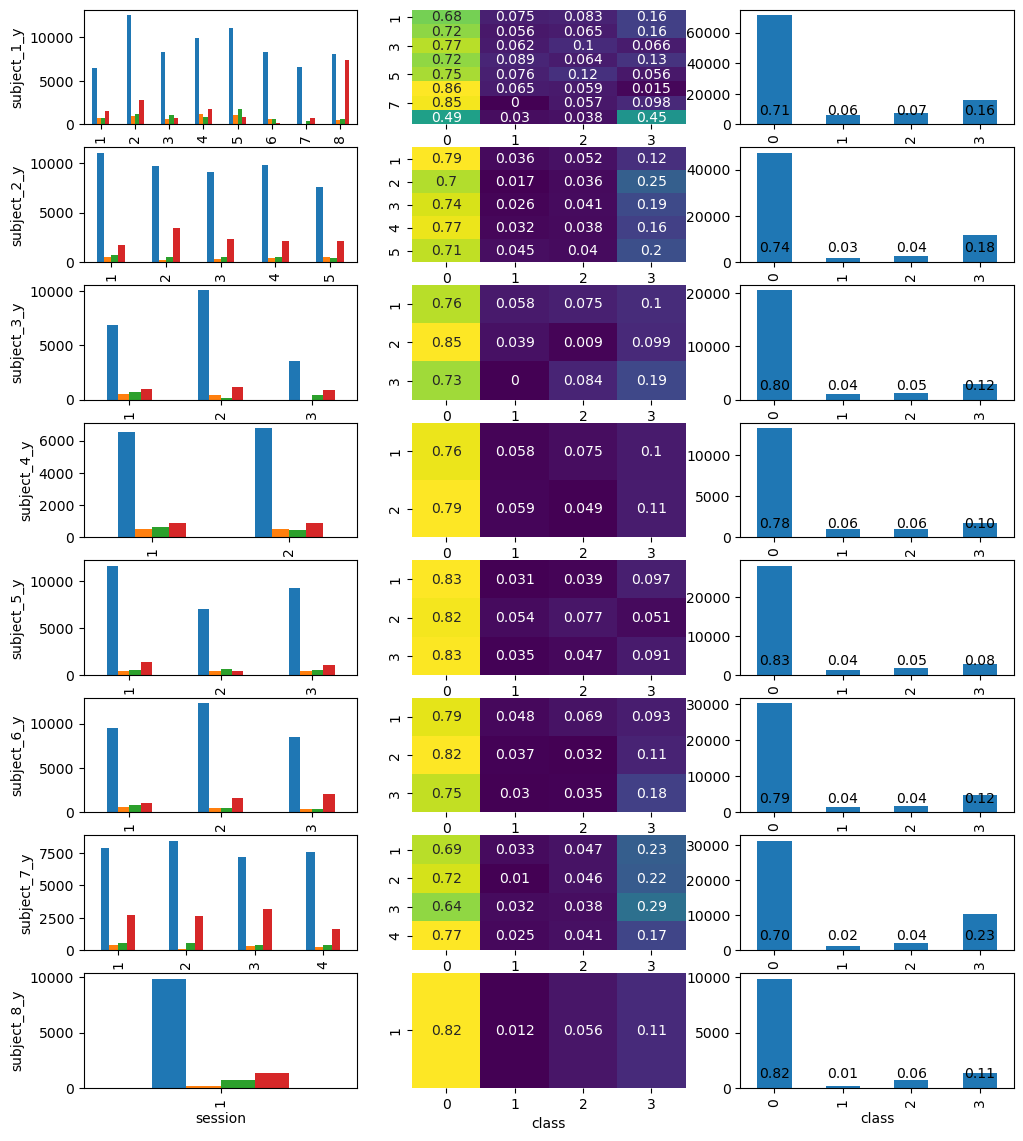

In [6]:
## Raw dataset
dctPerSess = {}
dctPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate([x for x in dctData.keys() if x.endswith('_y')]):
    dfclass = dctData[k]
    table = pd.pivot_table(dctData[k], values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctPerSess[k] = perSess
    dctPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [7]:
## count ocurrence of each class per subject and session
dctCountRaw = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for ik, k in enumerate([x for x in dctData.keys() if x.endswith('_y')]):
    dfs = dctData[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctCountRaw[k[:-2]].loc[s, aux.index] = aux.values

In [13]:
## upsample labels using nearest neighbor
dctUps = upsampleData(dctData)

subject 1
  upsampling session 1
    len X: 37890
    len y: 9473
    len data: 37890
  upsampling session 2
    len X: 70172
    len y: 17543
    len data: 70172
  upsampling session 3
    len X: 43146
    len y: 10787
    len data: 43146
  upsampling session 4
    len X: 54956
    len y: 13739
    len data: 54956
  upsampling session 5
    len X: 59121
    len y: 14780
    len data: 59121
  upsampling session 6
    len X: 38631
    len y: 9658
    len data: 38631
  upsampling session 7
    len X: 31423
    len y: 7856
    len data: 31423
  upsampling session 8
    len X: 66762
    len y: 16691
    len data: 66762
    len total data subject 1: 402101
subject 2
  upsampling session 1
    len X: 55999
    len y: 14000
    len data: 55999
  upsampling session 2
    len X: 55401
    len y: 13850
    len data: 55401
  upsampling session 3
    len X: 48797
    len y: 12199
    len data: 48797
  upsampling session 4
    len X: 51461
    len y: 12865
    len data: 51461
  upsampling session 5

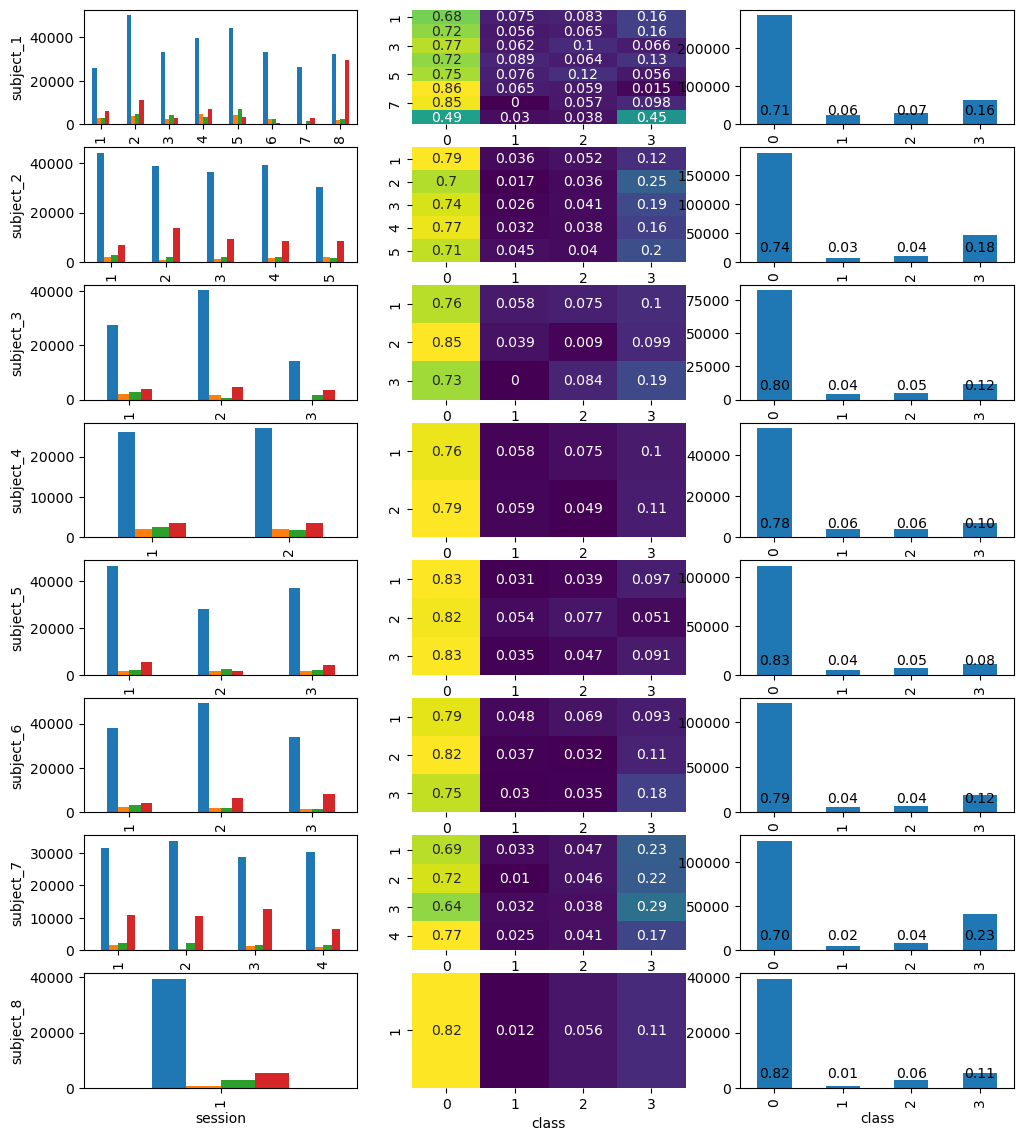

In [14]:
## Upsampled dataset
dctUpsPerSess = {}
dctUpsPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate(dctUps.keys()):
    dummy = dctUps[k][['class', 'session']]
    dummy['class'] = dummy['class'].astype('category')
    table = pd.pivot_table(dummy, values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctUpsPerSess[k] = perSess
    dctUpsPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctUpsPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [92]:
## the percentages do not change, since the values are just amplified by a factor of 4 due to the nearest
## neighbor interpolation. Seems to be correct!

In [15]:
## count number of timesteps for each session and subject
dctCountUps = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctCountUps[k].loc[s, aux.index] = aux.values

In [16]:
## get the number of instances needed for each class to make the dataset balanced
## the first and second more frequents classes per session (and subject) are set to 'threshold' times
## the third class in case they are larger.
dctCountBal = countBalance(dctCountUps, 2)

In [17]:
## randomly select values to match the number of calues in dctCountBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        numberClaUps = dctCountUps[k].loc[s, :]
        numberClaBal = dctCountBal[k].loc[s, :]
        
        out = []
        for c in numberClaUps.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfksc.sample(numberClaBal.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

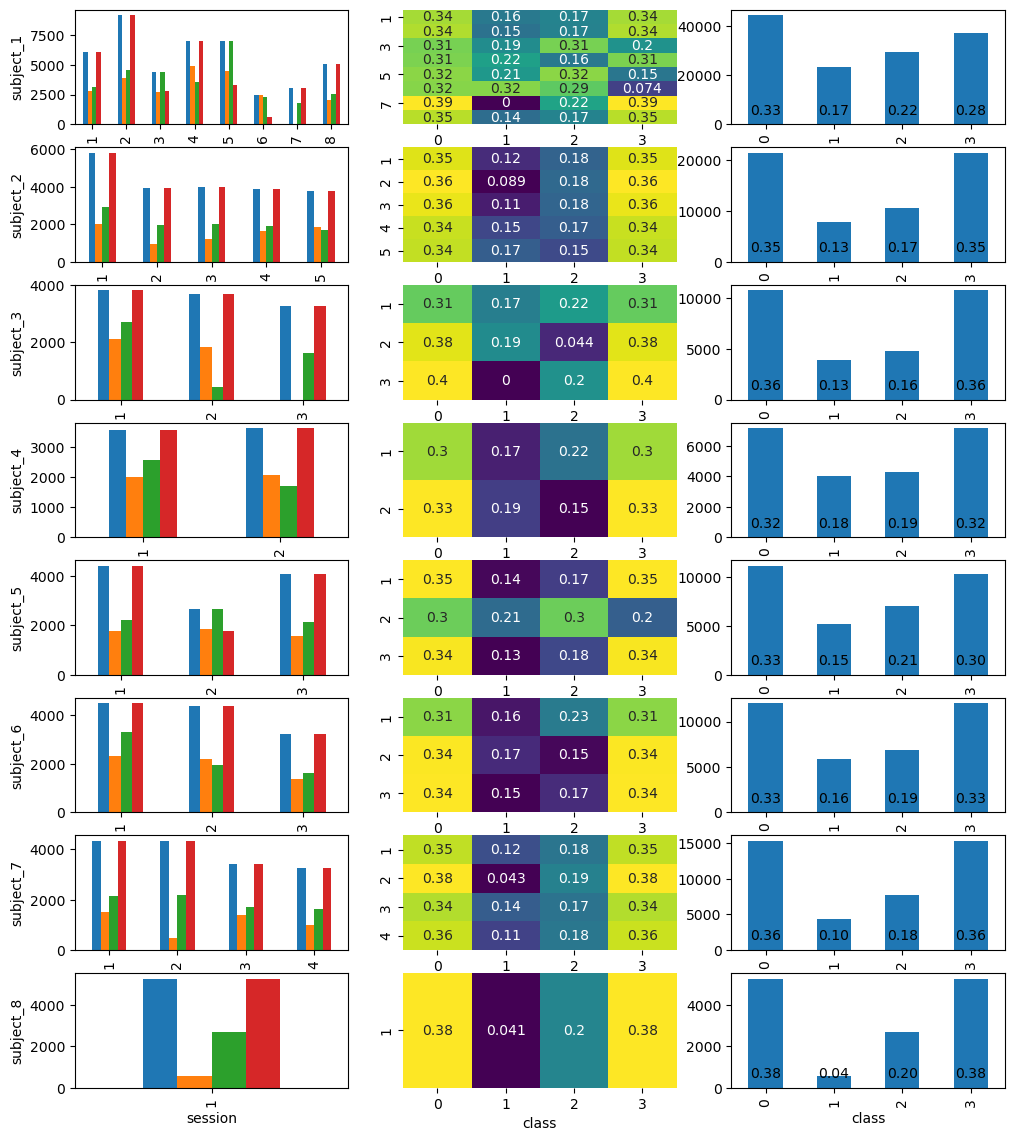

In [18]:
## Balanced dataset
dctUpsPerSess = {}
dctUpsPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate(dctUpsBal.keys()):
    dummy = dctUpsBal[k][['class', 'session']]
    dummy['class'] = dummy['class'].astype('category')
    table = pd.pivot_table(dummy, values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctUpsPerSess[k] = perSess
    dctUpsPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctUpsPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [158]:
with open('balancedDataset.pkl', 'wb') as fout:
    pickle.dump(dctUpsBal, fout)

In [19]:
testSessions = [(1,5), (2, 2), (3, 2), (4, 1), (5, 1), (6, 2), (7, 3)]
dfTest = []
dfTrain = []

cols = ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'class']
dfX, dfy = [], []
for k in dctUpsBal.keys():
    subject = k.split('_')[1]
    dfAux = dctUpsBal[k].drop(['time', 'class_time'], axis = 1)
    dfAux['subject'] = [int(subject)]*len(dfAux)
    try:
        sessionTesting = testSessions[int(subject)-1][1]
        dfAuxTest = dfAux[dfAux['session'] == sessionTesting]
        dfTest.append(dfAuxTest)
        dfAuxTrain = dfAux.drop(dfAuxTest.index, axis = 0)
        dfTrain.append(dfAuxTrain)
        print(f'subject {k} session {sessionTesting} saved for testing')
    except:
        print(f'subject {k} no session saved for testing')
        dfTrain.append(dfAux)

dfTrain = pd.concat(dfTrain, axis = 0)
dfTest = pd.concat(dfTest, axis = 0)

subject subject_1 session 5 saved for testing
subject subject_2 session 2 saved for testing
subject subject_3 session 2 saved for testing
subject subject_4 session 1 saved for testing
subject subject_5 session 1 saved for testing
subject subject_6 session 2 saved for testing
subject subject_7 session 3 saved for testing
subject subject_8 no session saved for testing


In [145]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=12, out_channels=36, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(num_features=36)
        self.cnn2 = nn.Conv1d(in_channels=36, out_channels=24, kernel_size=5, padding=2)
        self.avgpool1d = nn.AvgPool1d(kernel_size=5, padding=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=96, out_features=128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=96)
        self.fc3 = nn.Linear(in_features=96, out_features=32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(in_features=32, out_features=4)
        self.softmax = nn.Softmax(dim=1)
        self.dout = nn.Dropout(0.5)

    def forward(self, x):
        # print(x.shape)
        x = self.cnn1(x)
        x = F.relu(self.bn1(x))
        # print(f'Shape after 1st CNN: {x.shape}')
        x = self.avgpool1d(x)
        # print(f'Shape after 1st Pool: {x.shape}')
        x = F.relu(self.cnn2(x))
        # print(f'Shape after 1st CNN: {x.shape}')
        x = self.avgpool1d(x)
        # print(f'Shape after 1st Pool: {x.shape}')
        x = x.view(x.size(0), -1)
        # print(f'Shape after Flatten: {x.shape}')
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dout(x)
        x = F.relu(self.fc2(x))
        x = self.dout(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dout(x)
        x = F.softmax(self.fc4(x), dim = 1)
        # print(x.shape)
        return x


In [146]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, l2reg, dev, w):
    self.model = Net()
    if w != None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate, weight_decay=l2reg)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'val_loss': [],
                    'train_f1': [], 'val_f1': []}
    self.accuracy = []
    self.min_loss = np.inf
    self.max_f1 = 0
    self.best_weights = None

  def fit(self, tloader, vloader):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()

        lossList, f1List = [], []
        for b, (Xtrb, ytrb) in enumerate(tloader):
            Xtrb = Xtrb.permute(0, 2, 1).to(self.device)
            ytrb = ytrb.squeeze(2)
            ytrb, _ = torch.mode(ytrb, dim = 1)
            ytrb = ytrb.to(self.device)
            yPred = self.model(Xtrb)
            ## compute loss
            loss_tr = self.loss(yPred, ytrb)
            ## compute accuracy
            f1_tr = f1_score(yPred.cpu().detach().numpy().argmax(1).reshape(-1), 
                            ytrb.cpu().detach().numpy(), average='macro')
            ## backward propagation
            loss_tr.backward()
            self.optimizer.step()
            lossList.append(float(loss_tr.cpu().detach().numpy()))
            f1List.append(f1_tr)

        self.history[r'train_loss'].append(np.mean(lossList))
        self.history[r'train_f1'].append(np.mean(f1List))
          
        ########### Evaluation
        self.model.eval()
        lossList, f1List = [], []
        with torch.no_grad():
            for b, (Xvalb, yvalb) in enumerate(vloader):
                Xvalb = Xvalb.permute(0, 2, 1).to(self.device)
                yvalb = yvalb.squeeze(2)
                yvalb, _ = torch.mode(yvalb, dim = 1)
                yvalb = yvalb.to(self.device)
                yPred = self.model(Xvalb)
                ## compute loss
                loss_val = self.loss(yPred, yvalb)
                loss_val = float(loss_val.cpu().detach().numpy())
                ## compute accuracy
                f1_val = f1_score(yPred.cpu().detach().numpy().argmax(1).reshape(-1), 
                                yvalb.cpu().detach().numpy(), average='macro')
                lossList.append(loss_val)
                f1List.append(f1_val)

        self.history[r'val_loss'].append(np.mean(lossList))
        self.history[r'val_f1'].append(np.mean(f1List))

        if self.history[r'val_f1'][-1] > self.max_f1:
          self.min_loss = self.history[r'val_f1'][-1]
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%100 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'val_loss'][t]
          c = self.history[f'train_f1'][t]
          d = self.history[f'val_f1'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f} Training f1: {c:0.3f} - Validation f1: {d:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = X.permute(0, 2, 1)
    X = X.to(self.device)
    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

Epoch 0/1000. Training loss: 1.393 - Validation loss: 1.376 Training f1: 0.241 - Validation f1: 0.134
Epoch 100/1000. Training loss: 1.056 - Validation loss: 1.349 Training f1: 0.347 - Validation f1: 0.187
Epoch 200/1000. Training loss: 0.963 - Validation loss: 1.306 Training f1: 0.385 - Validation f1: 0.210
Epoch 300/1000. Training loss: 0.906 - Validation loss: 1.356 Training f1: 0.582 - Validation f1: 0.235
Epoch 400/1000. Training loss: 0.878 - Validation loss: 1.405 Training f1: 0.614 - Validation f1: 0.236
Epoch 500/1000. Training loss: 0.880 - Validation loss: 1.406 Training f1: 0.612 - Validation f1: 0.222
Epoch 600/1000. Training loss: 0.875 - Validation loss: 1.408 Training f1: 0.617 - Validation f1: 0.236
Epoch 700/1000. Training loss: 0.874 - Validation loss: 1.397 Training f1: 0.616 - Validation f1: 0.238
Epoch 800/1000. Training loss: 0.876 - Validation loss: 1.409 Training f1: 0.614 - Validation f1: 0.232
Epoch 900/1000. Training loss: 0.862 - Validation loss: 1.417 Trai

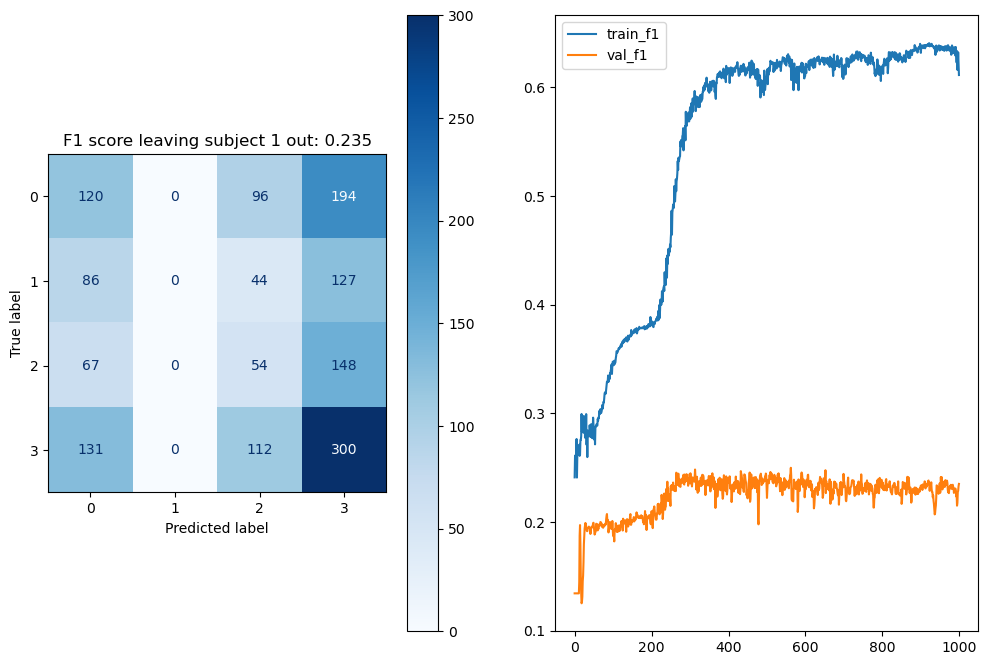

In [147]:
seq_len = 80 # length of each sequence
overlap = 76 # overlapping between sequences
bsize = 112_000
L2reg = 1e-5
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3

for kVal in range(1,9):

    table = pd.pivot_table(dfTrain[dfTrain['subject'] != kVal][['class', 'session']], 
                        values='class', index='session', columns='class', 
                        aggfunc=len, fill_value=0)
    
    weights = torch.tensor((table.sum(axis = 0)/table.sum().sum()).values.astype('float32'))
    weights = weights.to(device)

    arrXtr = dfTrain[dfTrain['subject'] != kVal].iloc[:, :6].values
    arrXtr = np.concatenate([arrXtr, np.abs(np.fft.fft(arrXtr))], axis = 1)
    dfytr = dfTrain.loc[dfXtr.index, ['class']]

    arrXvl = dfTrain[dfTrain['subject'] == kVal].iloc[:, :6].values
    arrXvl = np.concatenate([arrXvl, np.abs(np.fft.fft(arrXvl))], axis = 1)
    dfyvl = dfTrain.loc[dfXvl.index, ['class']]

    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(arrXtr)
    Xvl_sc = scaler.transform(arrXvl)

    Xtr = torch.tensor(Xtr_sc.astype('float32'))
    ytr = torch.tensor(dfytr.values.astype('int64'))

    Xvl = torch.tensor(Xvl_sc.astype('float32'))
    yvl = torch.tensor(dfyvl.values.astype('int64'))

    tr_sequences = []
    vl_sequences = []

    # create sequences for training data
    for i in range(0, len(Xtr)-seq_len, overlap):
        seq_X = Xtr[i:i+seq_len]
        seq_y = ytr[i:i+seq_len]
        tr_sequences.append((seq_X, seq_y))

    # create sequences for validation data
    for i in range(0, len(Xvl)-seq_len, overlap):
        seq_X = Xvl[i:i+seq_len]
        seq_y = yvl[i:i+seq_len]
        vl_sequences.append((seq_X, seq_y))

    trLoader = DataLoader(tr_sequences, batch_size = bsize, shuffle = False)
    vlLoader = DataLoader(vl_sequences, batch_size = bsize, shuffle = False)

    net = NetWrapper(1_000, learning_rate, L2reg, device, weights)
    dfhist, minLoss, bestModel = net.fit(trLoader, vlLoader)

    preds = []
    trues = []
    for b, (Xvalb, yvalb) in enumerate(vlLoader):
        predB = net.predict(Xvalb).argmax(axis = 1)
        preds.extend(predB)
        yvalb = yvalb.squeeze(2)
        yvalb, _ = torch.mode(yvalb, dim = 1)
        trues.extend(yvalb.detach().numpy())

    m = confusion_matrix(trues, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (12, 8), ncols = 2)
    disp.plot(ax = ax[0],  cmap = plt.cm.Blues)
    ax[0].set_title(f"F1 score leaving subject {kVal} out: {f1_score(preds, trues, average='macro'):0.3f}")
    dfhist[['train_f1', 'val_f1']].plot(ax = ax[1])


    break

Epoch 0/10000. Training loss: 1.398 - Validation loss: 1.388 Training f1: 0.230 - Validation f1: 0.109
Epoch 100/10000. Training loss: 1.378 - Validation loss: 1.382 Training f1: 0.252 - Validation f1: 0.173
Epoch 200/10000. Training loss: 1.343 - Validation loss: 1.377 Training f1: 0.279 - Validation f1: 0.194
Epoch 300/10000. Training loss: 1.298 - Validation loss: 1.369 Training f1: 0.298 - Validation f1: 0.198
Epoch 400/10000. Training loss: 1.235 - Validation loss: 1.361 Training f1: 0.321 - Validation f1: 0.194
Epoch 500/10000. Training loss: 1.182 - Validation loss: 1.352 Training f1: 0.321 - Validation f1: 0.199
Epoch 600/10000. Training loss: 1.134 - Validation loss: 1.345 Training f1: 0.346 - Validation f1: 0.201
Epoch 700/10000. Training loss: 1.093 - Validation loss: 1.340 Training f1: 0.352 - Validation f1: 0.203
Epoch 800/10000. Training loss: 1.063 - Validation loss: 1.337 Training f1: 0.357 - Validation f1: 0.201
Epoch 900/10000. Training loss: 1.040 - Validation loss: 

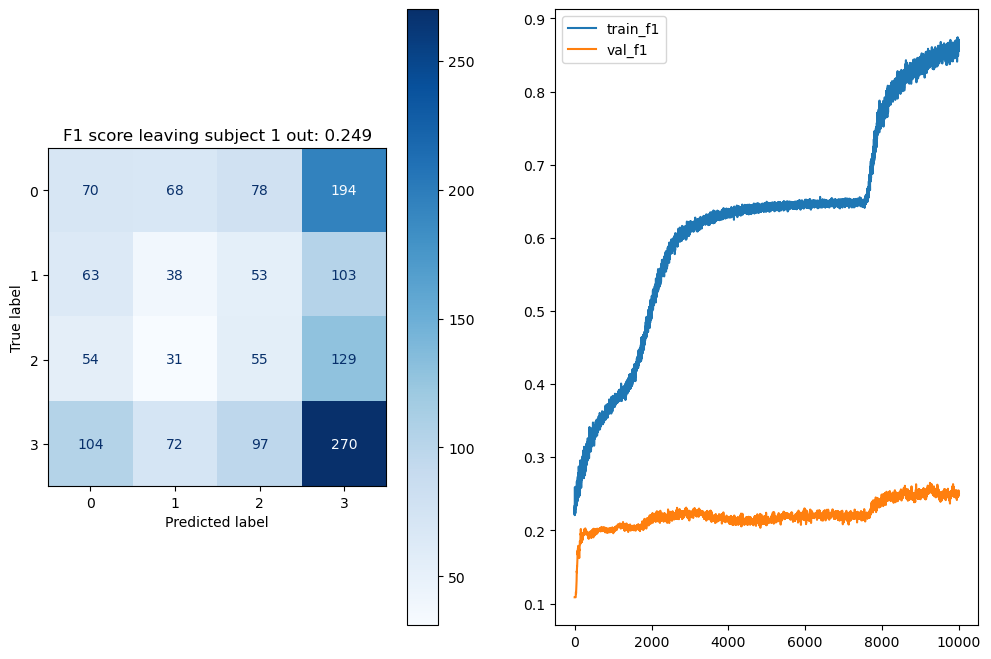

In [110]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=11, padding=5)
        self.bn1 = nn.BatchNorm1d(num_features=12)
        self.cnn2 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=9, padding=4)
        self.maxpool1d = nn.MaxPool1d(kernel_size=5, padding=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=96, out_features=96)
        self.bn2 = nn.BatchNorm1d(96)
        self.fc2 = nn.Linear(in_features=96, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(in_features=32, out_features=4)
        self.softmax = nn.Softmax(dim=1)
        self.dout = nn.Dropout(0.5)

    def forward(self, x):
        # print(x.shape)
        x = self.cnn1(x)
        x = F.relu(self.bn1(x))
        # print(f'Shape after 1st CNN: {x.shape}')
        x = self.maxpool1d(x)
        # print(f'Shape after 1st Pool: {x.shape}')
        x = F.relu(self.cnn2(x))
        # print(f'Shape after 1st CNN: {x.shape}')
        x = self.maxpool1d(x)
        # print(f'Shape after 1st Pool: {x.shape}')
        x = x.view(x.size(0), -1)
        # print(f'Shape after Flatten: {x.shape}')
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dout(x)
        x = F.relu(self.fc2(x))
        x = self.dout(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dout(x)
        x = F.softmax(self.fc4(x), dim = 1)
        # print(x.shape)
        return x

seq_len = 80 # length of each sequence
overlap = 76 # overlapping between sequences
bsize = 56_000
L2reg = 1e-5
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

for kVal in range(1,9):

    table = pd.pivot_table(dfTrain[dfTrain['subject'] != kVal][['class', 'session']], 
                        values='class', index='session', columns='class', 
                        aggfunc=len, fill_value=0)
    
    weights = torch.tensor((table.sum(axis = 0)/table.sum().sum()).values.astype('float32'))
    weights = weights.to(device)

    dfXtr = dfTrain[dfTrain['subject'] != kVal].iloc[:, :6]
    dfytr = dfTrain.loc[dfXtr.index, ['class']]

    dfXvl = dfTrain[dfTrain['subject'] == kVal].iloc[:, :6]
    dfyvl = dfTrain.loc[dfXvl.index, ['class']]

    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(dfXtr)
    Xvl_sc = scaler.transform(dfXvl)

    Xtr = torch.tensor(Xtr_sc.astype('float32'))
    ytr = torch.tensor(dfytr.values.astype('int64'))

    Xvl = torch.tensor(Xvl_sc.astype('float32'))
    yvl = torch.tensor(dfyvl.values.astype('int64'))

    tr_sequences = []
    vl_sequences = []

    # create sequences for training data
    for i in range(0, len(Xtr)-seq_len, overlap):
        seq_X = Xtr[i:i+seq_len]
        seq_y = ytr[i:i+seq_len]
        tr_sequences.append((seq_X, seq_y))

    # create sequences for validation data
    for i in range(0, len(Xvl)-seq_len, overlap):
        seq_X = Xvl[i:i+seq_len]
        seq_y = yvl[i:i+seq_len]
        vl_sequences.append((seq_X, seq_y))

    trLoader = DataLoader(tr_sequences, batch_size = bsize, shuffle = False)
    vlLoader = DataLoader(vl_sequences, batch_size = bsize, shuffle = False)

    net = NetWrapper(10_000, learning_rate, L2reg, device, weights)
    dfhist, minLoss, bestModel = net.fit(trLoader, vlLoader)

    preds = []
    trues = []
    for b, (Xvalb, yvalb) in enumerate(vlLoader):
        predB = net.predict(Xvalb).argmax(axis = 1)
        preds.extend(predB)
        yvalb = yvalb.squeeze(2)
        yvalb, _ = torch.mode(yvalb, dim = 1)
        trues.extend(yvalb.detach().numpy())

    m = confusion_matrix(trues, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (12, 8), ncols = 2)
    disp.plot(ax = ax[0],  cmap = plt.cm.Blues)
    ax[0].set_title(f"F1 score leaving subject {kVal} out: {f1_score(preds, trues, average='macro'):0.3f}")
    dfhist[['train_f1', 'val_f1']].plot(ax = ax[1])


    break